# Finding Lane Lines on the Road

## Loading Libraries
matplotlib is used for Plotting
cv2 refers to OpenCV2(Open Computer Vision 2)
> OpenCV was designed for computational efficiency and with a strong focus on real-time applications(ex,. Computer Vision). Written in optimized C/C++, the library can take advantage of multi-core processing. Enabled with OpenCL, it can take advantage of the hardware acceleration of the underlying heterogeneous compute platform.

In [36]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os, glob
import cv2
%matplotlib inline

## Some Helper Functions

Below are some helper functions to perform image operations/transformations/region and lane markings etc.

In [9]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def average_lines(lines):

    # To find slope & intercept values (m,b)
    def compute_coef(line):
        line= list(line.flatten())
        x1,y1,x2,y2 = line
        m = (y2-y1)/(x2-x1)
        b = y1-m*x1
        return m, b

    # To find end points for each line
    def m_b_to_points(m,b):

        y1=540
        x1=(y1-b)/ m

        y2=320
        x2=(y2-b)/ m
        return int(x1),int(y1),int(x2),int(y2)
    
    left_line = list()
    right_line = list()
    
    for line in lines:
        m, b = compute_coef(line)
        if  m> 0:
            left_line.append((m,b))
        else:
            right_line.append((m,b))

    left_line = np.array(left_line)
    right_line = np.array(right_line)
    left_line = np.median(left_line,axis=0)
    right_line = np.median(right_line,axis=0)
    right_line = m_b_to_points(*right_line)
    left_line = m_b_to_points(*left_line)
    
    return np.array([left_line,right_line])


def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    ## The below step converts segments of lines to a full line (either sides of lines, from hough transform)
    lines = average_lines(lines)  

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    color=[255, 0, 0]
    thickness=6
    for line in lines:
        x1,y1,x2,y2 = list(line)
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    
    return line_img, lines

# Understanding the flow/procedure 
in order to find the lanes on the road, using helper functions!


Plotting All the Images at each stage!



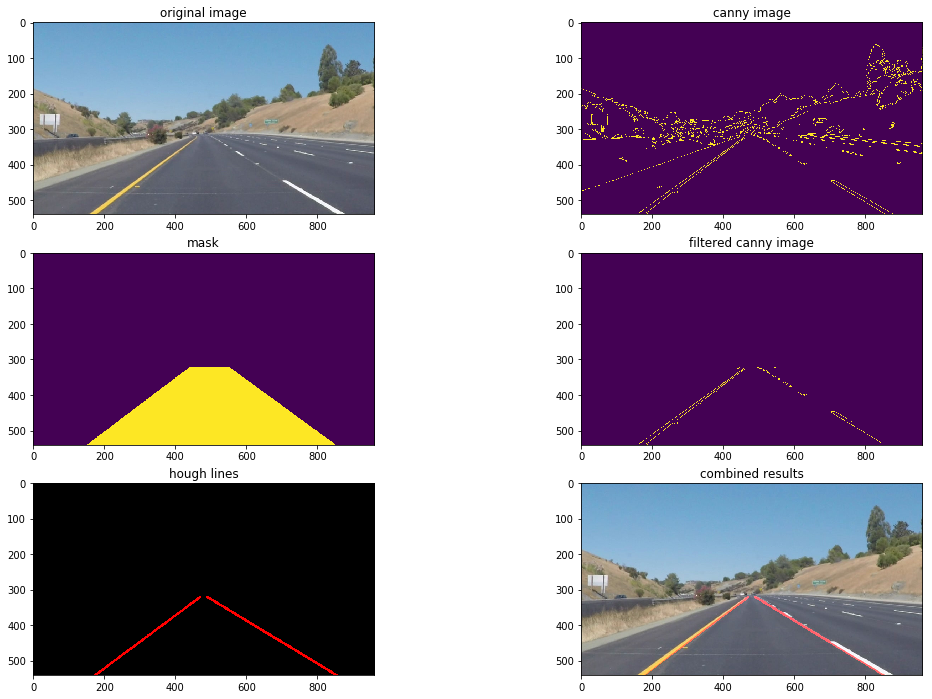

In [29]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_gray  = grayscale(image)
image_blur = gaussian_blur(image_gray,7)
canny_map = canny(image, 45, 180)
_vertices = np.array([[[150,540],[440,320],[550,320],[850,540]]],dtype=np.int32)

canny_map_filtered, mask = region_of_interest(canny_map,_vertices)

hough_img,lines = hough_lines2(canny_map_filtered,rho=2,theta=np.pi/180,threshold=15, min_line_len=40,max_line_gap=20)

## Plotting All the images at each stage!! 
print('\n======================================')
print('Plotting All the Images at each stage!')
print('======================================\n')

plt.figure(figsize=(18,12))
plt.subplot(3,2,1)
plt.title('original image')
plt.imshow(image)
plt.subplot(3,2,2)
plt.title('canny image')
plt.imshow(canny_map)
plt.subplot(3,2,3)
plt.title('mask')
plt.imshow(mask)
plt.subplot(3,2,4)
plt.title('filtered canny image')
plt.imshow(canny_map_filtered)
plt.subplot(3,2,5)
plt.title('hough lines')
plt.imshow(hough_img)
plt.subplot(3,2,6)
plt.title('combined results')
plt.imshow(weighted_img(image,hough_img))
plt.savefig('pipeline.png')

## Pipleine

The following techniques are used and applied in the same order to detect lanes:

    . Color Selection(Gray Scale)
    . Gaussian Smoothing
    . Canny Edge Detection
    . Region of Interest Selection
    . Hough Transform Line Detection

Finally, I applied all the techniques to process video clips to find lane lines(on each frame) in them

In [28]:
def process_image(image):
    image_gray  = grayscale(image)
    image_blur = gaussian_blur(image_gray,7)
    canny_map = canny(image, 45, 180)
    imshape = image.shape
    _vertices = np.array([[(int(0.1 * imshape[1]),imshape[0]),
                       (int(0.45 * imshape[1]),int(0.6 * imshape[0])),
                       (int(0.55 * imshape[1]),int(0.6 * imshape[0])),
                       (int(0.9 * imshape[1]),imshape[0])]]) #, dtype=np.int32

    canny_map_filtered, mask = region_of_interest(canny_map,_vertices)

    hough_img,lines = hough_lines2(canny_map_filtered,rho=2,theta=np.pi/180,threshold=15, min_line_len=40,max_line_gap=20)
    return weighted_img(image,hough_img)

## Testing other images using the same pipeline

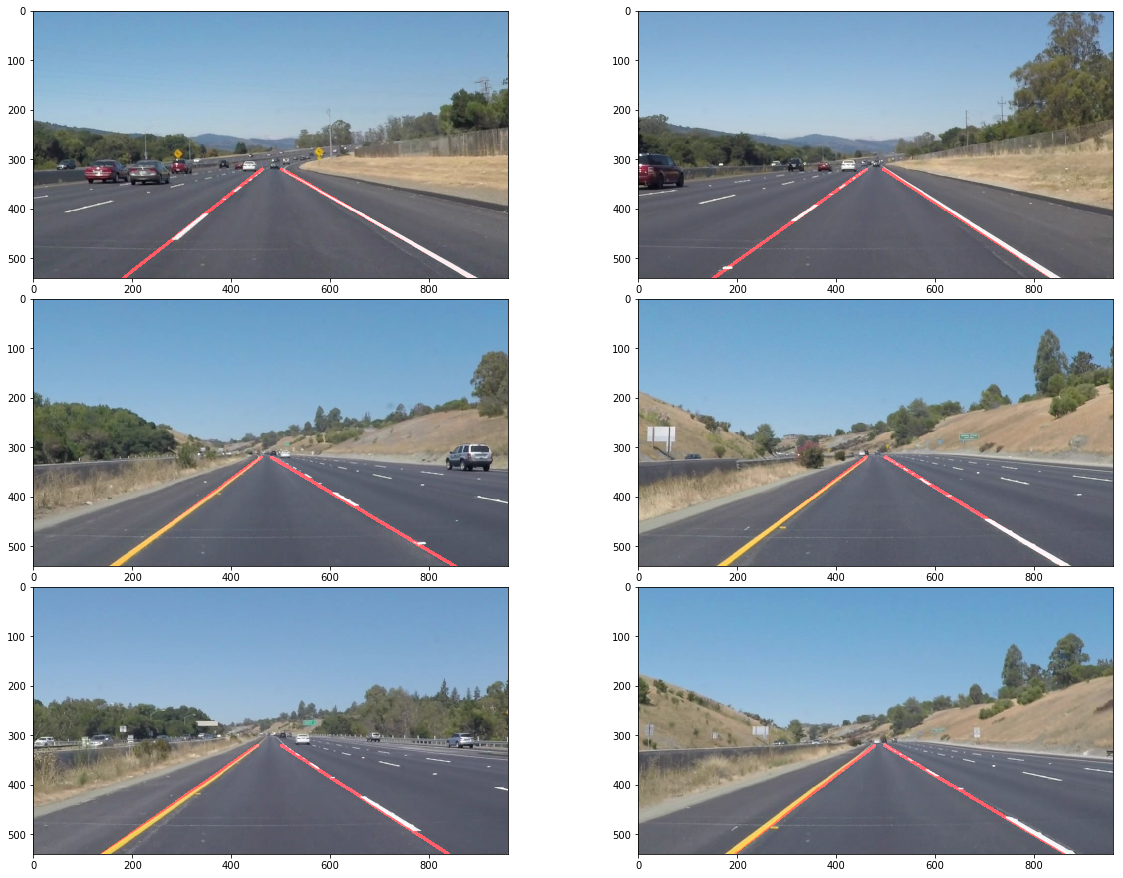

In [52]:
test_image_names = os.listdir("test_images/")
test_image_output_folder = 'test_image_output/'
cols = 2
rows = (len(test_image_names)+1)//cols
    
plt.figure(figsize=(18, 12))
for i in range(len(test_image_names)):
    test_image = test_image_names[i]
    image = mpimg.imread('test_images/' + test_image)
    image_w_lanes = process_image(image)
    plt.subplot(rows, cols, i+1)
    plt.imshow(image_w_lanes)
    cv2.imwrite('test_image_output/' + test_image, image_w_lanes)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)    
plt.show()

## Finding Lanes in a Video stream
Applying find_lanes function on each frame of a video

Testing the solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Video: 
solidWhiteRight.mp4

In [59]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 32.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.86 s


In [61]:
# Stream Output Video after finding lanes

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Video:
solidYellowLeft.mp4

In [60]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:25<00:00, 26.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 26.4 s


In [62]:
# Stream Output Video after finding lanes

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))